In [1]:
import numpy as np
import os 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from openpyxl import Workbook

import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import gaussian_kde
from scipy.stats import ttest_rel

In [2]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['legend.facecolor'] = 'white' 

File read and organize the data

In [4]:
df_reward = pd.read_excel('reward_quest.xlsx')
df_punish = pd.read_excel('punishment_quest.xlsx')
df_mixed = pd.read_excel('mixed_quest.xlsx')
df_p_memory1 = pd.read_csv('punishment_memory_summary.csv')
df_r_memory1 = pd.read_csv('reward_memory_summary.csv', on_bad_lines='skip')
df_m_memory1 = pd.read_csv('mixed_memory_summary.csv')
df_m_fmri = pd.read_csv('mixed_fmribehav_summary.csv')
df_r_fmri = pd.read_csv('reward_fmribehav_summary.csv')
df_p_fmri = pd.read_csv('punishment_fmribehav_summary.csv')

C:\Users\18611\AppData\Local\Temp\ipykernel_3704\612948028.py:4: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_p_memory1 = pd.read_csv('punishment_memory_summary.csv')


In [5]:
df_p_memory1['rt'] = pd.to_numeric(df_p_memory1['rt'], errors='coerce')
df_p_memory1 = df_p_memory1.dropna(subset=['rt'])
df_r_memory1['rt'] = pd.to_numeric(df_r_memory1['rt'], errors='coerce')
df_r_memory1 = df_r_memory1.dropna(subset=['rt'])
df_m_memory1['rt'] = pd.to_numeric(df_m_memory1['rt'], errors='coerce')
df_m_memory1 = df_m_memory1.dropna(subset=['rt'])

df_m_memory1['meta'] = 1 - (df_m_memory1['accuracy'] - df_m_memory1['confidence']/100)**2
df_r_memory1['meta'] = 1 - (df_r_memory1['accuracy'] - df_r_memory1['confidence']/100)**2
df_p_memory1['meta'] = 1 - (df_p_memory1['accuracy'] - df_p_memory1['confidence']/100)**2

In [6]:
df_r_memory = df_r_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    acc=('accuracy', 'mean'),
    conf=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    RT=('rt', 'mean'),
    MAD=('MAD', 'mean')
).reset_index()

df_m_memory = df_m_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    acc=('accuracy', 'mean'),
    conf=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    RT=('rt', 'mean'),
    MAD=('MAD', 'mean')
).reset_index()

df_p_memory = df_p_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    acc=('accuracy', 'mean'),
    conf=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    RT=('rt', 'mean'),
    MAD=('MAD', 'mean')
).reset_index()

In [7]:
sub_list_reward = df_r_memory['subject_nr'].unique()
cond_list_reward = df_r_memory['condition'].unique()
stage_list_reward = df_r_memory['stage'].unique()

sub_list_punishment = df_p_memory['subject_nr'].unique()
cond_list_punishment = df_p_memory['condition'].unique()
stage_list_punishment = df_p_memory['stage'].unique()

sub_list_mixed = df_m_memory['subject_nr'].unique()
cond_list_mixed= df_m_memory['condition'].unique()
stage_list_mixed= df_m_memory['stage'].unique()

In [8]:
df_r_fmri['reward_prob_1'] = df_r_fmri['money_prob_1']
df_r_fmri['reward_prob_2'] = df_r_fmri['money_prob_2']
df_p_fmri['reward_prob_1'] = 10 - df_p_fmri['electric_prob_1']
df_p_fmri['reward_prob_2'] = 10 - df_p_fmri['electric_prob_2']

Calculate the lie-rate and lie-entropy

In [9]:
def calculate_lierate(fmridata, sub_list):
    # Filter data
    fmridata = fmridata[fmridata['subj'].isin(sub_list)]
    fmridata = fmridata[fmridata['rt'] <= 4]
    fmridata.reset_index(drop=True, inplace=True)
    
    # Initialize reward_sign column
    fmridata['reward_sign'] = -1

    # Calculate reward_sign based on menu positions and probabilities
    for i in range(len(fmridata)):
        menu_position_1 = fmridata.iloc[i]['menu_position_1']
        reward_prob_1 = fmridata.iloc[i]['reward_prob_1']
        reward_prob_2 = fmridata.iloc[i]['reward_prob_2']
        
        if menu_position_1 > 36:
            if reward_prob_1 > reward_prob_2:
                fmridata.loc[i, 'reward_sign'] = 1  # Using .loc to avoid SettingWithCopyWarning
            elif reward_prob_1 < reward_prob_2:
                fmridata.loc[i, 'reward_sign'] = 0
        else:
            if reward_prob_1 > reward_prob_2:
                fmridata.loc[i, 'reward_sign'] = 0
            elif reward_prob_1 < reward_prob_2:
                fmridata.loc[i, 'reward_sign'] = 1

    # Calculate reward_gain based on choices
    fmridata['reward_gain'] = None
    for i in range(len(fmridata)):
        menu_position_1 = fmridata.iloc[i]['menu_position_1']
        menu_position_2 = fmridata.iloc[i]['menu_position_2']
        choose = fmridata.iloc[i]['choose']
        
        if pd.notna(menu_position_1) and pd.notna(choose) and menu_position_1 == choose:
            fmridata.loc[i, 'reward_gain'] = fmridata.iloc[i]['reward_prob_1']
        elif pd.notna(menu_position_2) and pd.notna(choose) and menu_position_2 == choose:
            fmridata.loc[i, 'reward_gain'] = fmridata.iloc[i]['reward_prob_2']
            
    return fmridata

In [10]:
def agg_entropy(fmridata):   
    # Calculate lie-rate for each subject, menu, and condition
    agg_menu = fmridata.groupby(['subj', 'menu', 'condition']).agg(
        lierate=('islie', 'mean'),
        scan_rt=('rt', lambda x: np.mean(pd.to_numeric(x, errors='coerce'))),
        reward_sign=('reward_sign', 'mean'),
        reward_gain_sum=('reward_gain', 'sum')
    ).reset_index()

    # Calculate average lie-rate per subject and condition
    agg_entropy = agg_menu.groupby(['subj', 'condition']).agg(
        lierate=('lierate', 'mean')
    ).reset_index()
    
    # Calculate entropy (information theory measure of uncertainty)
    agg_entropy['entropy'] = -agg_entropy['lierate'] * np.log2(agg_entropy['lierate']) - \
                            (1 - agg_entropy['lierate']) * np.log2(1 - agg_entropy['lierate'])
    
    # Handle edge cases where lierate is 0 or 1
    agg_entropy.loc[agg_entropy['lierate'] == 1, 'entropy'] = 0
    agg_entropy.loc[agg_entropy['lierate'] == 0, 'entropy'] = 0
    
    return agg_entropy, agg_menu

In [11]:
df_p_fmri2 = calculate_lierate(df_p_fmri, sub_list_punishment)
df_r_fmri2 = calculate_lierate(df_r_fmri, sub_list_reward)
df_m_fmri2 = calculate_lierate(df_m_fmri, sub_list_mixed)

# Calculate lie-rates and entropy
agg_p_lie_entro, agg_p_menu = agg_entropy(df_p_fmri2)
agg_r_lie_entro, agg_r_menu = agg_entropy(df_r_fmri2)
agg_m_lie_entro, agg_m_menu = agg_entropy(df_m_fmri2)

c:\Users\18611\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\18611\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\18611\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Plot the lie-rate and entropy


c:\Users\18611\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\18611\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\18611\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


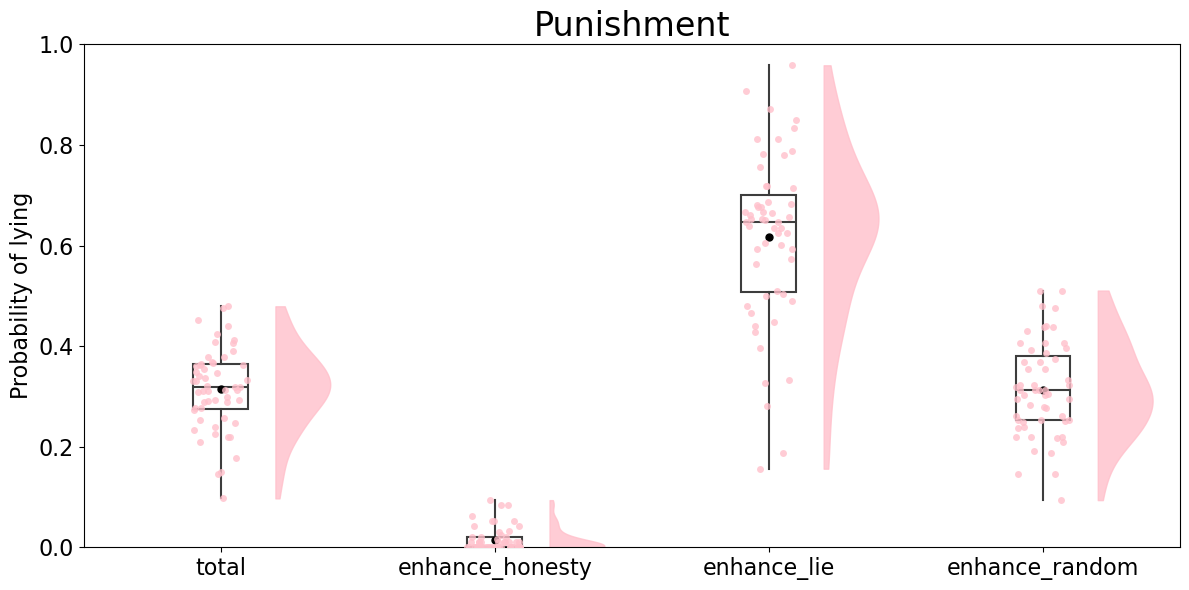

c:\Users\18611\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\18611\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\18611\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


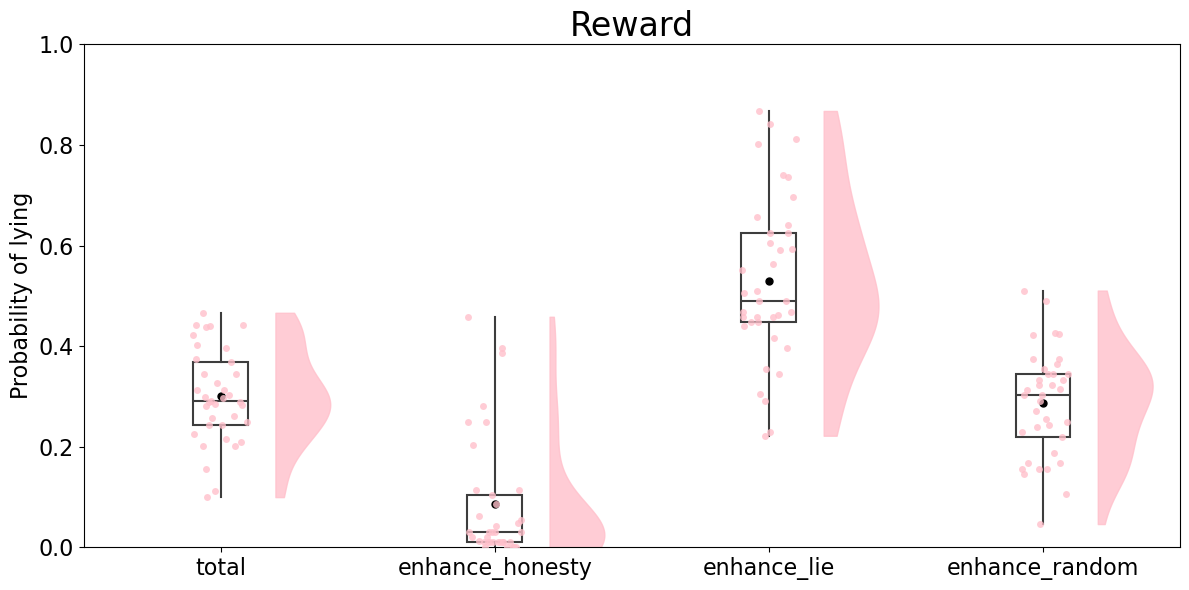

c:\Users\18611\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\18611\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\18611\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


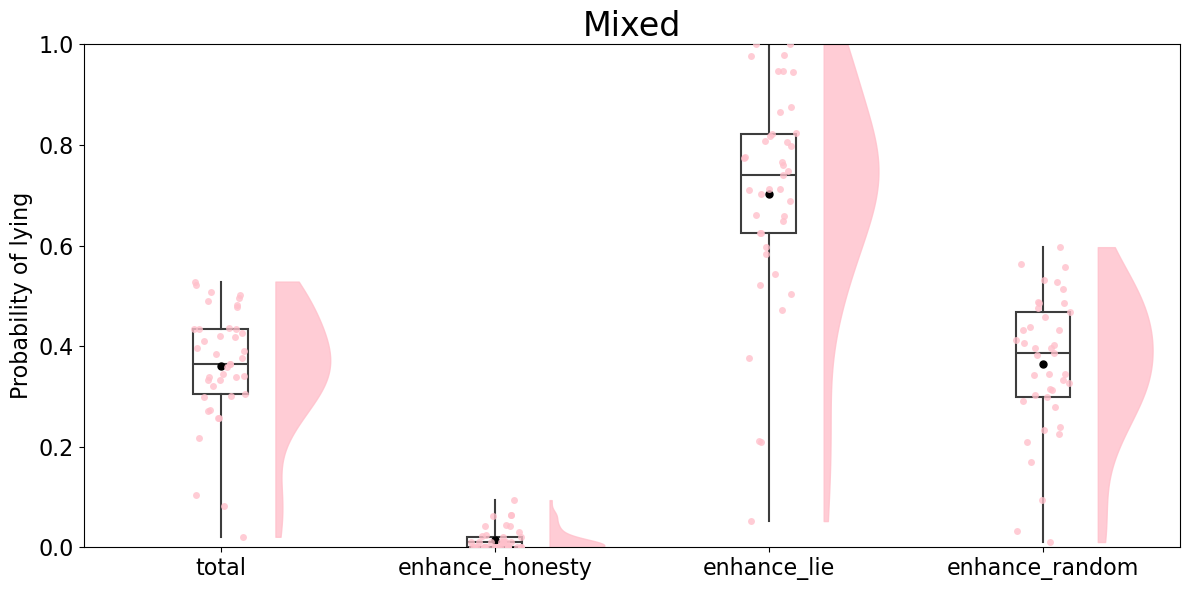

In [12]:
def add_total_condition(agg_lie_entro):
    total_lie_rate = agg_lie_entro.groupby('subj')['lierate'].mean().reset_index()
    total_lie_rate['condition'] = 'total'
    combined = pd.concat([agg_lie_entro, total_lie_rate], ignore_index=True)
    # Reorder conditions
    combined['condition'] = pd.Categorical(combined['condition'], categories=['total'] + list(agg_lie_entro['condition'].unique()), ordered=True)
    return combined

# Add the 'total' condition to each dataset
agg_p_lie_entro_total = add_total_condition(agg_p_lie_entro)
agg_r_lie_entro_total = add_total_condition(agg_r_lie_entro)
agg_m_lie_entro_total = add_total_condition(agg_m_lie_entro)

def plot_lie_rate_with_strip(agg_lie_entro, title):
    plt.figure(figsize=(12, 6))
    
    # Plot KDE for each condition
    for i, condition in enumerate(['total', 'enhance_honesty', 'enhance_lie', 'enhance_random']):
        subset = agg_lie_entro[agg_lie_entro['condition'] == condition]
        kde = gaussian_kde(subset['lierate'])
        #y_values = np.linspace(0, 1, 1000)
        y_values = np.linspace(min(subset['lierate']), max(subset['lierate']), 1000)
        kde_values = kde(y_values)
        kde_values = kde_values / kde_values.max() * 0.2 
        plt.fill_betweenx(y_values, i + 0.2, kde_values + i + 0.2, color='pink', alpha=0.8)
        

    sns.boxplot(data=agg_lie_entro, x='condition', y='lierate', whis=[0, 100], width=0.2, 
                showcaps=False, boxprops={'facecolor':'None'}, showmeans=True, meanprops={"marker":"o",
                "markerfacecolor":"black", "markeredgecolor":"black", "markersize":"5"})
    

    sns.stripplot(data=agg_lie_entro, x='condition', y='lierate', color='pink', jitter=True, size=5, alpha=0.8)
    
    #plt.xlim(-0.5, len(agg_lie_entro['condition'].unique()) - 0.5 + 0.5)
    plt.title(title, fontsize=24)
    plt.xlabel('')
    plt.ylabel('Probability of lying', fontsize=16)
    plt.ylim(0, 1)
    plt.xticks(rotation=0, fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

plot_lie_rate_with_strip(agg_p_lie_entro_total, 'Punishment')
plot_lie_rate_with_strip(agg_r_lie_entro_total, 'Reward')
plot_lie_rate_with_strip(agg_m_lie_entro_total, 'Mixed')

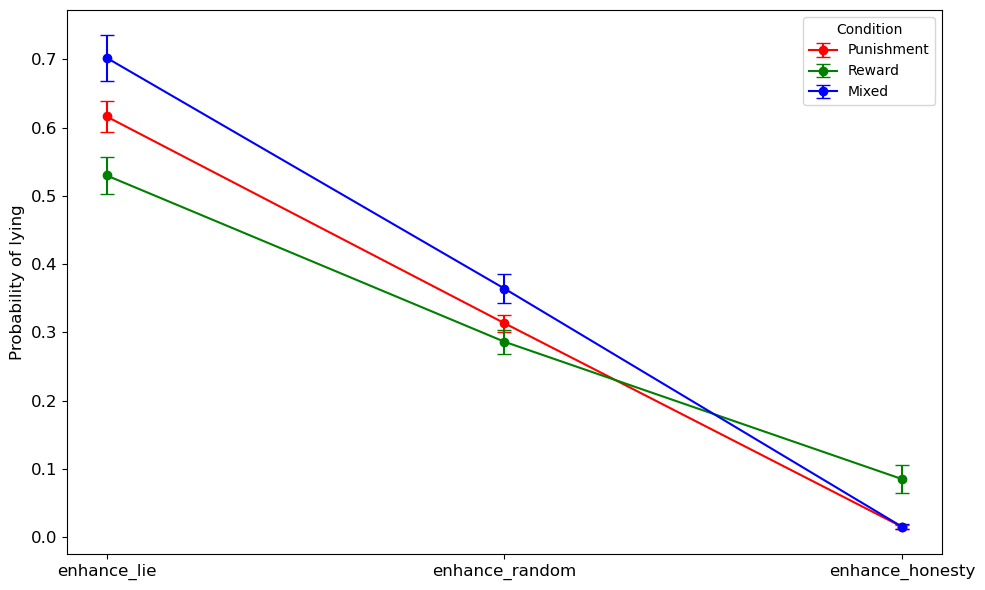

In [13]:
def plot_lierate_lines(agg_p, agg_r, agg_m):

    conditions = ['enhance_lie', 'enhance_random', 'enhance_honesty']
    colors = ['red', 'green', 'blue']
    labels = ['Punishment', 'Reward', 'Mixed']
    

    plt.figure(figsize=(10, 6))
    
    for i, (agg, label) in enumerate(zip([agg_p, agg_r, agg_m], labels)):
        means = [agg[agg['condition'] == condition]['lierate'].mean() for condition in conditions]
        errors = [agg[agg['condition'] == condition]['lierate'].sem() for condition in conditions]
        
        plt.errorbar(conditions, means, yerr=errors, marker='o', color=colors[i], label=label, capsize=5)
    
    #plt.title('Lierate Across Conditions', fontsize=16)
    #plt.xlabel('Condition', fontsize=12)
    plt.ylabel('Probability of lying', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Condition')
    plt.tight_layout()
    plt.show()


plot_lierate_lines(agg_p_lie_entro_total, agg_r_lie_entro_total, agg_m_lie_entro_total)

Calculate the memory change and plot


In [14]:
def calculate_metric(data, metric, sub_list, cond_list, stage_list):
    result = np.zeros((len(sub_list), len(cond_list), len(stage_list)))
    
    for i, sub in enumerate(sub_list):
        sub_data = data[data['subject_nr'] == sub]
        for j, cond in enumerate(cond_list):
            cond_data = sub_data[sub_data['condition'] == cond]
            for k, stage in enumerate(stage_list):
                stage_data = cond_data[cond_data['stage'] == stage]
                result[i, j, k] = stage_data[metric].mean()
    
    return result


cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']
stage_list = ['pre', 'post', 'post2']

rt_reward = calculate_metric(df_r_memory, 'RT', sub_list_reward, cond_list, stage_list)
acc_reward = calculate_metric(df_r_memory, 'acc', sub_list_reward, cond_list, stage_list)
confidence_reward = calculate_metric(df_r_memory, 'conf', sub_list_reward, cond_list, stage_list)
mad_reward = calculate_metric(df_r_memory, 'MAD', sub_list_reward, cond_list, stage_list)
auc_reward = calculate_metric(df_r_memory, 'AUC', sub_list_reward, cond_list, stage_list)
meta_reward = calculate_metric(df_r_memory, 'meta', sub_list_reward, cond_list, stage_list)


rt_punish = calculate_metric(df_p_memory, 'RT', sub_list_punishment, cond_list, stage_list)
acc_punish = calculate_metric(df_p_memory, 'acc', sub_list_punishment, cond_list, stage_list)
confidence_punish = calculate_metric(df_p_memory, 'conf', sub_list_punishment, cond_list, stage_list)
mad_punish = calculate_metric(df_p_memory, 'MAD', sub_list_punishment, cond_list, stage_list)
auc_punish = calculate_metric(df_p_memory, 'AUC', sub_list_punishment, cond_list, stage_list)
meta_punish = calculate_metric(df_p_memory, 'meta', sub_list_punishment, cond_list, stage_list)

rt_mixed = calculate_metric(df_m_memory, 'RT', sub_list_mixed, cond_list, stage_list)
acc_mixed = calculate_metric(df_m_memory, 'acc', sub_list_mixed, cond_list, stage_list)
confidence_mixed = calculate_metric(df_m_memory, 'conf', sub_list_mixed, cond_list, stage_list)
mad_mixed = calculate_metric(df_m_memory, 'MAD', sub_list_mixed, cond_list, stage_list)
auc_mixed = calculate_metric(df_m_memory, 'AUC', sub_list_mixed, cond_list, stage_list)
meta_mixed = calculate_metric(df_m_memory, 'meta', sub_list_mixed, cond_list, stage_list)

Get the behavior performance and plot it

In [15]:
def plot_behavior_bar_two_stages(data, cond_list, stage_list, title , ylimit, y_label):

    data = data[:, :, :2]

    means = np.mean(data, axis=0)
    errors = np.std(data, axis=0) / np.sqrt(data.shape[0])

    plt.figure(figsize=(10, 6))

    bar_width = 0.3
    for i, stage in enumerate(stage_list[:2]):
        plt.bar(np.arange(len(cond_list)) + i * bar_width, means[:, i], yerr=errors[:, i], 
                width=bar_width, label=stage, capsize=5)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(np.arange(len(cond_list))+ bar_width / 2, cond_list, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(ylimit)
    plt.legend(title='Stage')
    #plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
def ttest_behavior_two_stages(data, parameter_name):
    data = data[:, :, :2]
    t_value, p_value = ttest_rel(data[:, 0, 0], data[:, 0, 1])
    if p_value < 0.05:
        print(f'{parameter_name} honesty condition. t-value: {t_value}, p-value: {p_value}')
    t_value, p_value = ttest_rel(data[:, 1, 0], data[:, 1, 1])
    if p_value < 0.05:
        print(f'{parameter_name} lie condition. t-value: {t_value}, p-value: {p_value}')
    t_value, p_value = ttest_rel(data[:, 2, 0], data[:, 2, 1])
    if p_value < 0.05:
        print(f'{parameter_name} random condition. t-value: {t_value}, p-value: {p_value}')


In [ ]:
#Calculate the t-test score for each parameter
'''
ttest_behavior_two_stages(acc_reward, 'Accuracy Reward')
ttest_behavior_two_stages(rt_reward, 'Reaction Time Reward')
ttest_behavior_two_stages(confidence_reward, 'Confidence Reward')
ttest_behavior_two_stages(mad_reward, 'MAD Reward')
ttest_behavior_two_stages(auc_reward, 'AUC Reward')
ttest_behavior_two_stages(meta_reward, 'Meta Reward')

ttest_behavior_two_stages(acc_punish, 'Accuracy Punishment')
ttest_behavior_two_stages(rt_punish, 'Reaction Time Punishment')
ttest_behavior_two_stages(confidence_punish, 'Confidence Punishment')
ttest_behavior_two_stages(mad_punish, 'MAD Punishment')
ttest_behavior_two_stages(auc_punish, 'AUC Punishment')
ttest_behavior_two_stages(meta_punish, 'Meta Punishment')

ttest_behavior_two_stages(acc_mixed, 'Accuracy Mixed')
ttest_behavior_two_stages(rt_mixed, 'RT Mixed')
ttest_behavior_two_stages(confidence_mixed, 'Confidence Mixed')
ttest_behavior_two_stages(mad_mixed, 'MAD Mixed')
ttest_behavior_two_stages(auc_mixed, 'AUC Mixed')
ttest_behavior_two_stages(meta_mixed, 'Meta Mixed')

'''

In [ ]:
#plot the behavior result
'''
plot_behavior_bar_two_stages(acc_reward, cond_list, stage_list, 'Reward',[0.85,1],'Accuracy')
plot_behavior_bar_two_stages(acc_punish, cond_list, stage_list, 'Punishment',[0.85,1],'Accuracy')
plot_behavior_bar_two_stages(acc_mixed, cond_list, stage_list, 'Mixed',[0.85,1],'Accuracy')

plot_behavior_bar_two_stages(rt_reward, cond_list, stage_list, 'Reward',[950,1350],'Reaction Time(ms)')
plot_behavior_bar_two_stages(rt_punish, cond_list, stage_list, 'Punishment',[950,1350],'Reaction Time(ms)')
plot_behavior_bar_two_stages(rt_mixed, cond_list, stage_list, 'Mixed',[950,1350],'Reaction Time(ms)')

plot_behavior_bar_two_stages(confidence_reward, cond_list, stage_list, 'Reward',[85,105],'Confidence')
plot_behavior_bar_two_stages(confidence_punish, cond_list, stage_list, 'Punishment',[85,105],'Confidence')
plot_behavior_bar_two_stages(confidence_mixed, cond_list, stage_list, 'Mixed',[85,105],'Confidence')

plot_behavior_bar_two_stages(meta_reward, cond_list, stage_list, 'Reward',[0.85,1.05],'Meta Confidence')
plot_behavior_bar_two_stages(meta_punish, cond_list, stage_list, 'Punishment',[0.85,1.05],'Meta Confidence')
plot_behavior_bar_two_stages(meta_mixed, cond_list, stage_list, 'Mixed',[0.85,1.05],'Meta Confidence')

plot_behavior_bar_two_stages(auc_reward, cond_list, stage_list, 'Reward',[0.2,0.5],'AUC')
plot_behavior_bar_two_stages(auc_punish, cond_list, stage_list, 'Punishment',[0.2,0.5],'AUC')
plot_behavior_bar_two_stages(auc_mixed, cond_list, stage_list, 'Mixed',[0.2,0.5],'AUC')

plot_behavior_bar_two_stages(mad_reward, cond_list, stage_list, 'Reward',[0.4,0.8],'MAD value')
plot_behavior_bar_two_stages(mad_punish, cond_list, stage_list, 'Punishment',[0.4,0.8],'MAD value')
plot_behavior_bar_two_stages(mad_mixed, cond_list, stage_list, 'Mixed',[0.4,0.8],'MAD value')
'''



Get the Emotional value from three study and get the correlation figure

In [17]:

def plot_correlation(df, col1, col2, xlabel, ylabel):

    plt.figure(figsize=(8, 6))
    
    sns.set_theme(style="whitegrid")

    sns.scatterplot(data=df, x=col1, y=col2, color='white', alpha=0.7, s=80, marker="o", edgecolor='blue', linewidth=2)
    sns.regplot(data=df, x=col1, y=col2, scatter=False, color='blue', line_kws={"linewidth": 2})
    
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    plt.grid(visible=True, linestyle="--", alpha=0.4)

    plt.show()

In [18]:
col_name_list_p = df_punish.columns.tolist()
reward_emotion_list = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]
punish_emotion_list = [26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]
mixed_emotion_list = [26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]

emotion_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total']


col_nn = col_name_list_p[punish_emotion_list[0]]
emo_value_p = df_punish[col_nn]
data_punish = np.zeros([len(sub_list_punishment), len(emotion_list)])

for i in range(len(sub_list_punishment)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_punish[i,j] = df_punish[col_nn][df_punish.iloc[:, 6] == sub_list_punishment[i]].to_numpy()[0]

In [19]:
beh_list = ['lierate_honesty','lie_entropy_honesty','acc_drop_honesty','meta_drop_honesty',
            'rt_drop_honesty','conf_drop_honesty','auc_drop_honesty',
            'lierate_dishonest','lie_entropy_dishonest','acc_drop_dishonest','meta_drop_dishonest',
            'rt_drop_dishonest','conf_drop_dishonest','auc_drop_dishonest',
            'lierate_random','lie_entropy_random','acc_drop_random','meta_drop_random',
            'rt_drop_random','conf_drop_random','auc_drop_random']
data_punish_beh = np.zeros([len(sub_list_punishment), len(beh_list)])

cond_list_name = ['enhance_honesty','enhance_lie','enhance_random']

for k in range(3):   
    for i in range(len(sub_list_punishment)):
        agg_sub = agg_p_lie_entro[agg_p_lie_entro['subj'] == sub_list_punishment[i]]
        data_punish_beh[i,k*7+0] = agg_sub[agg_sub['condition'] == cond_list_name[k]]['lierate'].to_numpy()[0]
        data_punish_beh[i,k*7+1] = agg_sub[agg_sub['condition'] == cond_list_name[k]]['entropy'].to_numpy()[0]

    cond_index = k
    data_punish_beh[:,k*7+3] = meta_punish[:,cond_index,0] - meta_punish[:,cond_index,1]
    data_punish_beh[:,k*7+2] = acc_punish[:,cond_index,0] - acc_punish[:,cond_index,1]
    data_punish_beh[:,k*7+4] = np.abs(rt_punish[:,cond_index,0] - rt_punish[:,cond_index,1])
    data_punish_beh[:,k*7+5] = confidence_punish[:,cond_index,0] - confidence_punish[:,cond_index,1]
    data_punish_beh[:,k*7+6] = auc_punish[:,cond_index,0] - auc_punish[:,cond_index,1]
    
data_punish_total = np.concatenate((data_punish, data_punish_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset',
               'Strong','Guilty','Scared','Hostile',
               'Enthusiastic','Proud','Irritable','Alert',
               'Ashamed','Inspired','Nervous','Determined',
               'Attentive','Jittery','Active','Afraid',
               'Pos','Neg','Total',
               'lierate_honesty','lie_entropy_honesty','acc_drop_honesty','meta_drop_honesty',
               'rt_drop_honesty','conf_drop_honesty','auc_drop_honesty',
               'lierate_dishonest','lie_entropy_dishonest','acc_drop_dishonest','meta_drop_dishonest',
               'rt_drop_dishonest','conf_drop_dishonest','auc_drop_dishonest',
               'lierate_random','lie_entropy_random','acc_drop_random','meta_drop_random',
               'rt_drop_random','conf_drop_random','auc_drop_random']
df_punish_final = pd.DataFrame(data_punish_total, columns=column_list)

In [20]:
data_reward = np.zeros([len(sub_list_reward), len(emotion_list)])

for i in range(len(sub_list_reward)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_reward[i,j] = df_reward[col_nn][df_reward.iloc[:, 1] == sub_list_reward[i]].to_numpy()[0]
        
beh_list = ['lierate_honesty','lie_entropy_honesty','acc_drop_honesty','meta_drop_honesty',
            'rt_drop_honesty','conf_drop_honesty','auc_drop_honesty',
            'lierate_dishonest','lie_entropy_dishonest','acc_drop_dishonest','meta_drop_dishonest',
            'rt_drop_dishonest','conf_drop_dishonest','auc_drop_dishonest',
            'lierate_random','lie_entropy_random','acc_drop_random','meta_drop_random',
            'rt_drop_random','conf_drop_random','auc_drop_random']

data_beh = np.zeros([len(sub_list_reward), len(beh_list)])

cond_list_name = ['enhance_honesty','enhance_lie','enhance_random']
for k in range(3):
    for i in range(len(sub_list_reward)):
        agg_sub = agg_r_lie_entro[agg_r_lie_entro['subj'] == sub_list_reward[i]]
        data_beh[i,k*7+0] = agg_sub[agg_sub['condition'] == cond_list_name[k]]['lierate'].to_numpy()[0]
        data_beh[i,k*7+1] = agg_sub[agg_sub['condition'] == cond_list_name[k]]['entropy'].to_numpy()[0]

    cond_index = k
    data_beh[:,k*7+3] = meta_reward[:,cond_index,0] - meta_reward[:,cond_index,1]
    data_beh[:,k*7+2] = acc_reward[:,cond_index,0] - acc_reward[:,cond_index,1]
    data_beh[:,k*7+4] = np.abs(rt_reward[:,cond_index,0] - rt_reward[:,cond_index,1])
    data_beh[:,k*7+5] = confidence_reward[:,cond_index,0] - confidence_reward[:,cond_index,1]
    data_beh[:,k*7+6] = auc_reward[:,cond_index,0] - auc_reward[:,cond_index,1]

data_total = np.concatenate((data_reward, data_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset',
               'Strong','Guilty','Scared','Hostile',
               'Enthusiastic','Proud','Irritable','Alert',
               'Ashamed','Inspired','Nervous','Determined',
               'Attentive','Jittery','Active','Afraid',
               'Pos','Neg','Total',
               'lierate_honesty','lie_entropy_honesty','acc_drop_honesty','meta_drop_honesty',
               'rt_drop_honesty','conf_drop_honesty','auc_drop_honesty',
               'lierate_dishonest','lie_entropy_dishonest','acc_drop_dishonest','meta_drop_dishonest',
               'rt_drop_dishonest','conf_drop_dishonest','auc_drop_dishonest',
               'lierate_random','lie_entropy_random','acc_drop_random','meta_drop_random',
               'rt_drop_random','conf_drop_random','auc_drop_random']
df_reward_final = pd.DataFrame(data_total, columns=column_list)

In [21]:
data_mixed = np.zeros([len(sub_list_mixed), len(emotion_list)])

for i in range(len(sub_list_mixed)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_mixed[i,j] = df_mixed[col_nn][df_mixed.iloc[:, 6] == sub_list_mixed[i]].to_numpy()[0]
        
beh_list = ['lierate_honesty','lie_entropy_honesty','acc_drop_honesty','meta_drop_honesty',
            'rt_drop_honesty','conf_drop_honesty','auc_drop_honesty',
            'lierate_dishonest','lie_entropy_dishonest','acc_drop_dishonest','meta_drop_dishonest',
            'rt_drop_dishonest','conf_drop_dishonest','auc_drop_dishonest',
            'lierate_random','lie_entropy_random','acc_drop_random','meta_drop_random',
            'rt_drop_random','conf_drop_random','auc_drop_random']
data_beh = np.zeros([len(sub_list_mixed), len(beh_list)])

cond_list_name = ['enhance_honesty','enhance_lie','enhance_random']
for k in range(3):
    for i in range(len(sub_list_mixed)):
        agg_sub = agg_m_lie_entro[agg_m_lie_entro['subj'] == sub_list_mixed[i]]
        data_beh[i,k*7+0] = agg_sub[agg_sub['condition'] == cond_list_name[k]]['lierate'].to_numpy()[0]
        data_beh[i,k*7+1] = agg_sub[agg_sub['condition'] == cond_list_name[k]]['entropy'].to_numpy()[0]

    cond_index = k
    data_beh[:,k*7+3] = meta_mixed[:,cond_index,0] - meta_mixed[:,cond_index,1]
    data_beh[:,k*7+2] = acc_mixed[:,cond_index,0] - acc_mixed[:,cond_index,1]
    data_beh[:,k*7+4] = np.abs(rt_mixed[:,cond_index,0] - rt_mixed[:,cond_index,1])
    data_beh[:,k*7+5] = confidence_mixed[:,cond_index,0] - confidence_mixed[:,cond_index,1]
    data_beh[:,k*7+6] = auc_mixed[:,cond_index,0] - auc_mixed[:,cond_index,1]

data_total = np.concatenate((data_mixed, data_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset',
               'Strong','Guilty','Scared','Hostile',
               'Enthusiastic','Proud','Irritable','Alert',
               'Ashamed','Inspired','Nervous','Determined',
               'Attentive','Jittery','Active','Afraid',
               'Pos','Neg','Total',
               'lierate_honesty','lie_entropy_honesty','acc_drop_honesty','meta_drop_honesty',
               'rt_drop_honesty','conf_drop_honesty','auc_drop_honesty',
               'lierate_dishonest','lie_entropy_dishonest','acc_drop_dishonest','meta_drop_dishonest',
               'rt_drop_dishonest','conf_drop_dishonest','auc_drop_dishonest',
               'lierate_random','lie_entropy_random','acc_drop_random','meta_drop_random',
               'rt_drop_random','conf_drop_random','auc_drop_random']
df_mixed_final = pd.DataFrame(data_total, columns=column_list)

In [ ]:
'''
plot_correlation(df_punish_final, 'Distressed', 'acc_drop_dishonest', 'Distressed Value','Accuracy Value Drop')
plot_correlation(df_punish_final, 'Distressed', 'meta_drop_dishonest', 'Distressed Value','Meta-Confidence Value Drop')
plot_correlation(df_reward_final, 'Distressed', 'auc_drop_dishonest', 'Distressed Value','AUC Value Drop')
plot_correlation(df_reward_final, 'Jittery', 'auc_drop_dishonest', 'Jittery Value','AUC Value Drop')
plot_correlation(df_mixed_final, 'Distressed', 'meta_drop_dishonest', 'Distressed Value','Meta-Confidence Value Drop')
plot_correlation(df_mixed_final, 'Strong', 'auc_drop_dishonest', 'Strong Value','AUC Value Drop')
'''

Compare and plot and difference among three conditions

In [22]:
def compare_and_plot(col_name):

    data_reward = df_reward_final[col_name]
    data_punish = df_punish_final[col_name]
    data_mixed = df_mixed_final[col_name]
    
    combined_df = pd.DataFrame({
        'Reward': data_reward,
        'Punishment': data_punish,
        'Mixed': data_mixed
    })

    melted_df = combined_df.melt(var_name='Condition', value_name=col_name)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Condition', y=col_name, data=melted_df, palette='Set2')
    sns.stripplot(x='Condition', y=col_name, data=melted_df, color='black', jitter=True, alpha=0.5)
    
    plt.title(f'Comparison of {col_name} Across Conditions', fontsize=16)
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel(col_name, fontsize=12)
    plt.grid(True)
    plt.show()


In [23]:
def anova_and_plot(col_name,ylabel):

    data_reward = df_reward_final[col_name]
    data_punish = df_punish_final[col_name]
    data_mixed = df_mixed_final[col_name]
    

    anova_result = f_oneway(data_reward, data_punish, data_mixed)
    print(f"ANOVA result for {col_name}: F={anova_result.statistic}, p={anova_result.pvalue}")
    

    combined_data = pd.concat([data_reward, data_punish, data_mixed], axis=0)
    conditions = ['Reward'] * len(data_reward) + ['Punishment'] * len(data_punish) + ['Mixed'] * len(data_mixed)
    

    tukey_result = pairwise_tukeyhsd(endog=combined_data, groups=conditions, alpha=0.05)
    print(tukey_result)

    combined_df = pd.DataFrame({
        'Condition': conditions,
        col_name: combined_data
    })
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Condition', y=col_name, data=combined_df, palette='Set2')
    sns.stripplot(x='Condition', y=col_name, data=combined_df, color='black', jitter=True, alpha=0.5)
    
    plt.title(f'Comparison of {ylabel} Across Conditions', fontsize=16)
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.show()



In [24]:
def anova_only(col_name):

    data_reward = df_reward_final[col_name]
    data_punish = df_punish_final[col_name]
    data_mixed = df_mixed_final[col_name]
    

    anova_result = f_oneway(data_reward, data_punish, data_mixed)

    
    if anova_result.pvalue < 0.05:
        print(f"ANOVA result for {col_name}: F={anova_result.statistic}, p={anova_result.pvalue}")
        combined_data = pd.concat([data_reward, data_punish, data_mixed], axis=0)
        conditions = ['Reward'] * len(data_reward) + ['Punishment'] * len(data_punish) + ['Mixed'] * len(data_mixed)
        

        tukey_result = pairwise_tukeyhsd(endog=combined_data, groups=conditions, alpha=0.05)
        print(tukey_result)


In [25]:
def bar_plot(col_name,y_limit):

    data_reward = df_reward_final[col_name]
    data_punish = df_punish_final[col_name]
    data_mixed = df_mixed_final[col_name]
    
    plt.figure(figsize=(4, 6))
    Condition_xaxis = ['Reward','Punishment','Mixed']
    data = [data_reward.mean(),data_punish.mean(),data_mixed.mean()]
    error = [data_reward.sem(),data_punish.sem(),data_mixed.sem()]
    plt.bar(Condition_xaxis,data,yerr=error,capsize=5)
    #plt.title(f'Comparison of {col_name} Across Conditions', fontsize=16)
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel(col_name, fontsize=12)
    plt.ylim(y_limit)   
    plt.grid(False)
    plt.show()
    

In [26]:
column_list = ['Interested','Distressed','Excited','Upset',
               'Strong','Guilty','Scared','Hostile',
               'Enthusiastic','Proud','Irritable','Alert',
               'Ashamed','Inspired','Nervous','Determined',
               'Attentive','Jittery','Active','Afraid',
               'Pos','Neg','Total']

for kk in column_list:
    anova_only(kk)

ANOVA result for Excited: F=3.762394997174885, p=0.02579606849815046
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
     Mixed Punishment     0.49 0.0451  0.0085 0.9715   True
     Mixed     Reward   0.5293 0.0499  0.0002 1.0585   True
Punishment     Reward   0.0393 0.9807 -0.4569 0.5355  False
-----------------------------------------------------------
ANOVA result for Strong: F=3.430287153256384, p=0.03533658890992154
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
     Mixed Punishment   0.4909 0.0365  0.0247 0.9571   True
     Mixed     Reward   0.1351 0.8065 -0.3772 0.6475  False
Punishment     Reward  -0.3558 0.1887 -0.8362 0.1246  False
-----------------------------------------------------------
ANOVA result for Enthus

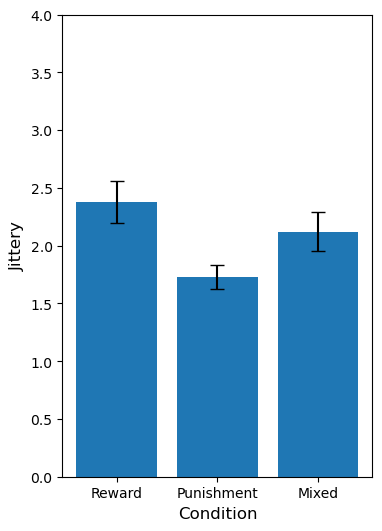

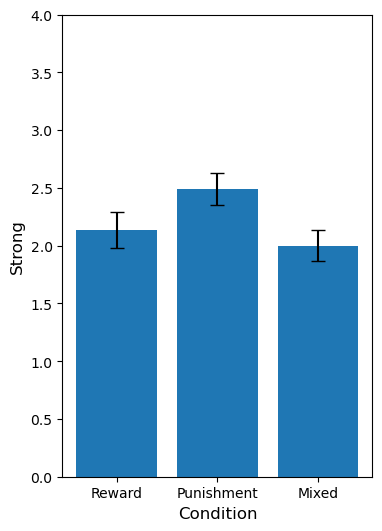

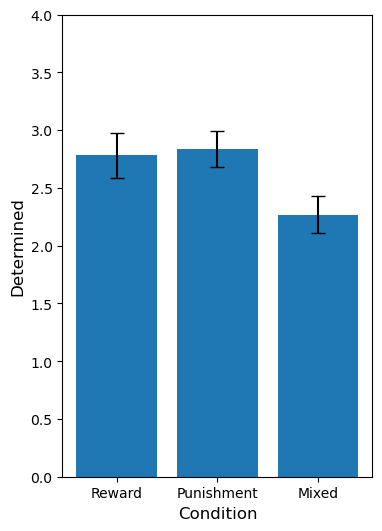

In [27]:
#Emotion value we used (Strong, Determined, Jittery)
bar_plot('Jittery',[0,4])
bar_plot('Strong',[0,4])
bar_plot('Determined',[0,4])

Download hDDM result

In [29]:
df_hddm_m = pd.read_csv('mixed_hddm_stats.csv')
df_hddm_r = pd.read_csv('reward_hddm_stats.csv')
df_hddm_p = pd.read_csv('punish_hddm_stats.csv')

df_hddm_m.rename(columns={'Unnamed: 0':'V1'}, inplace=True)
df_hddm_r.rename(columns={'Unnamed: 0':'V1'}, inplace=True)
df_hddm_p.rename(columns={'Unnamed: 0':'V1'}, inplace=True)

In [40]:
def get_hddm_para(ddm_results,subList):
    v_former_diff = ddm_results[ddm_results['V1'].str.contains("v_former_diff_subj")][['mean', 'V1']].reset_index(drop=True)
    v_ses = ddm_results[ddm_results['V1'].str.contains("v_ses_subj")][['mean', 'V1']].reset_index(drop=True)
    v_former_diff_ses = ddm_results[ddm_results['V1'].str.contains("v_former_diff:ses_subj")][['mean', 'V1']].reset_index(drop=True)
    v_diff = ddm_results[ddm_results['V1'].str.contains("v_diff_subj")][['mean', 'V1']].reset_index(drop=True)
    v_diff_ses = ddm_results[ddm_results['V1'].str.contains("v_diff:ses_subj")][['mean', 'V1']].reset_index(drop=True)
    a_ses = ddm_results[ddm_results['V1'].str.contains("a_ses_subj")][['mean', 'V1']].reset_index(drop=True)
    z_ses = ddm_results[ddm_results['V1'].str.contains("z_ses_subj")][['mean', 'V1']].reset_index(drop=True)

    # Combine the data
    ddm_params = pd.concat([
        v_former_diff[['mean']], 
        v_ses[['mean']], 
        v_former_diff_ses[['mean']], 
        v_diff[['mean']], 
        v_diff_ses[['mean']], 
        a_ses[['mean']], 
        z_ses[['mean']]
    ], axis=1)

    # Rename the columns
    ddm_params.columns = ['v_former_diff', 'v_ses', 'v_former_diff_ses', 'v_diff', 'v_diff_ses', 'a_ses', 'z_ses']

    # Add the subList as a new column
    ddm_params['subject_nr'] = subList
    
    return ddm_params

In [41]:
hddm_para_mixed = get_hddm_para(df_hddm_m,sub_list_mixed)
hddm_para_reward = get_hddm_para(df_hddm_r,sub_list_reward)
hddm_para_punish = get_hddm_para(df_hddm_p,sub_list_punishment)
parameter_list = hddm_para_mixed.columns.tolist()

In [42]:
print(len(data_reward) == len(hddm_para_reward))
print(len(data_punish) == len(hddm_para_punish))
print(len(data_mixed) == len(hddm_para_mixed))

True
True
True


Shapes before combining - Data: (37, 44), HDDM: (37, 8)
Shape after combining: (37, 52)


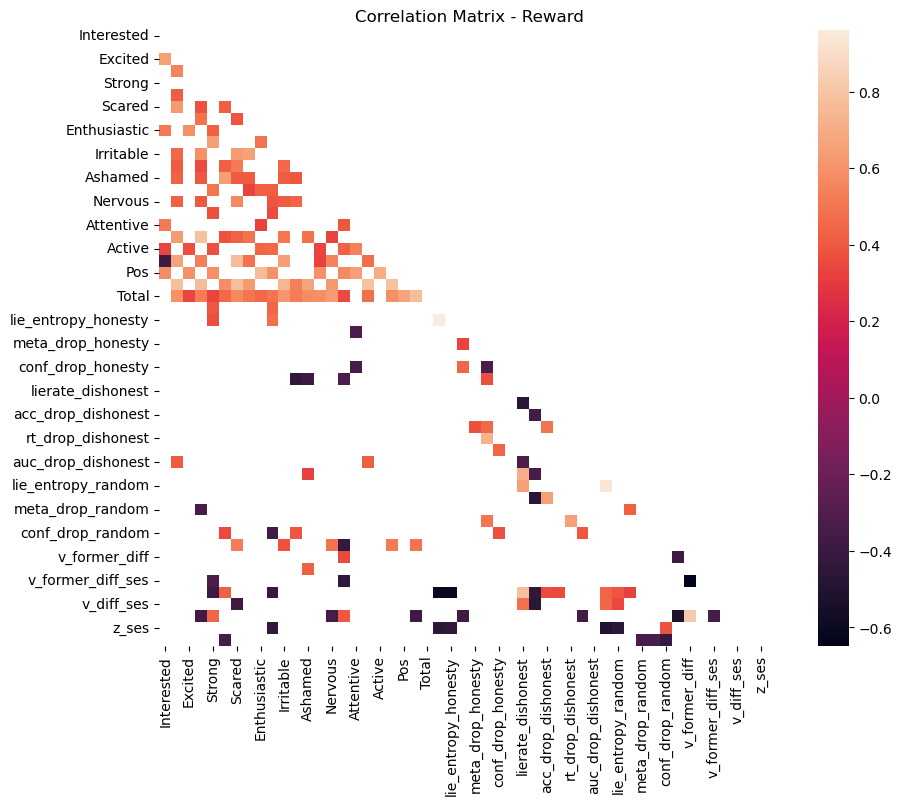

Shapes before combining - Data: (55, 44), HDDM: (55, 8)
Shape after combining: (55, 52)


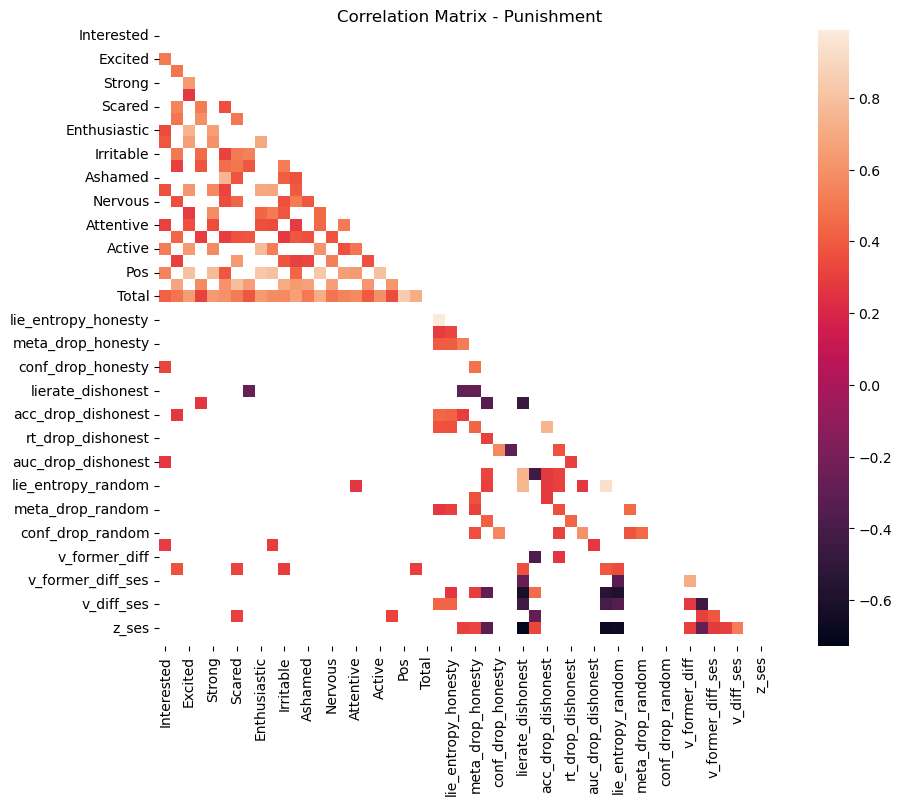

Shapes before combining - Data: (41, 44), HDDM: (41, 8)
Shape after combining: (41, 52)


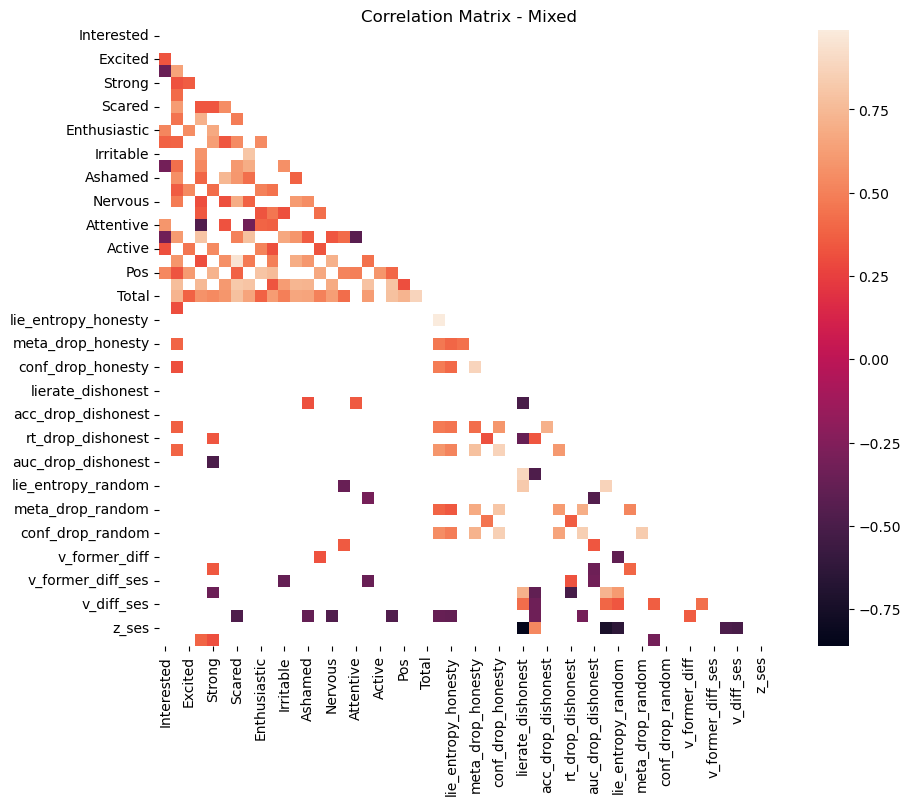

In [50]:
def combine_and_correlate(data_df, hddm_df, group_name):
    """
    Combines behavioral data with HDDM parameters and computes correlations.
    
    Parameters:
    data_df (pd.DataFrame): DataFrame containing behavioral data
    hddm_df (pd.DataFrame): DataFrame containing HDDM parameters
    group_name (str): Name of the group (reward/punishment/mixed)
    """
    # Print shapes before combining
    print(f"Shapes before combining - Data: {data_df.shape}, HDDM: {hddm_df.shape}")
    
    # Combine the dataframes horizontally
    combined_df = pd.concat([data_df, hddm_df], axis=1)
    
    # Print shape after combining
    print(f"Shape after combining: {combined_df.shape}")
    
    # Compute correlation matrix
    corr = combined_df.corr()
    
    # Compute p-value matrix
    p_matrix = np.zeros_like(corr)
    for i in range(len(corr)):
        for j in range(len(corr)):
            _, p_matrix[i, j] = pearsonr(combined_df.iloc[:, i], combined_df.iloc[:, j])
    
    # Create DataFrame for p-values
    p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
    df_pvalue = p_value_matrix.map(lambda x: round(x, 4))
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    alpha = 0.05
    mask_significant = p_matrix >= alpha
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    sns.heatmap(corr, mask=mask | mask_significant)
    plt.title(f'Correlation Matrix - {group_name}')
    plt.show()
    
    return combined_df, corr, df_pvalue

# Create combined dataframes and compute correlations for each group
combined_df_reward, corr_value_r, df_pvalue_r = combine_and_correlate(
    df_reward_final, hddm_para_reward, 'Reward'
)

combined_df_punish, corr_value_p, df_pvalue_p = combine_and_correlate(
    df_punish_final, hddm_para_punish, 'Punishment'
)

combined_df_mixed, corr_value_m, df_pvalue_m = combine_and_correlate(
    df_mixed_final, hddm_para_mixed, 'Mixed'
)


In [55]:
def check_significant_correlations(corr_df, p_value_df, threshold=0.05):
    """
    Identifies significant correlations where p < threshold.
    
    Parameters:
    corr_df (pd.DataFrame): Correlation matrix
    p_value_df (pd.DataFrame): P-value matrix
    threshold (float): Significance threshold (default: 0.05)
    """
    # Create mask for significant p-values
    significant_mask = p_value_df < threshold
    
    # Get significant correlations
    significant_corr = corr_df[significant_mask].copy()
    
    # Create a DataFrame to store significant results
    results = []
    for i in range(len(p_value_df)):
        for j in range(len(p_value_df)):
            if p_value_df.iloc[i, j] < threshold:
                results.append({
                    'Variable 1': p_value_df.index[i],
                    'Variable 2': p_value_df.columns[j],
                    'Correlation': round(corr_df.iloc[i, j], 3),
                    'P-value': round(p_value_df.iloc[i, j], 4)
                })
    
    # Convert results to DataFrame and sort by absolute correlation value
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df['Abs_Correlation'] = abs(results_df['Correlation'])
        results_df = results_df.sort_values('Abs_Correlation', ascending=False)
        results_df = results_df.drop('Abs_Correlation', axis=1)
    
    return results_df

# Check significant correlations for each condition
print("Significant correlations in Reward condition:")
sig_reward = check_significant_correlations(corr_value_r, df_pvalue_r)
print(sig_reward)
print("\nSignificant correlations in Punishment condition:")
sig_punish = check_significant_correlations(corr_value_p, df_pvalue_p)
print(sig_punish)
print("\nSignificant correlations in Mixed condition:")
sig_mixed = check_significant_correlations(corr_value_m, df_pvalue_m)
print(sig_mixed)


Significant correlations in Reward condition:
              Variable 1           Variable 2  Correlation  P-value
0             Interested           Interested        1.000   0.0000
202              Jittery              Jittery        1.000   0.0000
294    meta_drop_honesty    meta_drop_honesty        1.000   0.0000
289     acc_drop_honesty     acc_drop_honesty        1.000   0.0000
285  lie_entropy_honesty  lie_entropy_honesty        1.000   0.0000
..                   ...                  ...          ...      ...
181           Determined     auc_drop_honesty       -0.327   0.0484
415               v_diff      acc_drop_random        0.326   0.0493
366      acc_drop_random               v_diff        0.326   0.0493
192            Attentive     acc_drop_honesty       -0.325   0.0493
288     acc_drop_honesty            Attentive       -0.325   0.0493

[446 rows x 4 columns]

Significant correlations in Punishment condition:
              Variable 1           Variable 2  Correlation  P-v

In [57]:
def check_significant_correlations_with_variable(corr_df, p_value_df, target_var, threshold=0.05):
    """
    Identifies significant correlations between target variable and all other variables.
    
    Parameters:
    corr_df (pd.DataFrame): Correlation matrix
    p_value_df (pd.DataFrame): P-value matrix
    target_var (str): Name of the target variable (e.g., 'v_diff')
    threshold (float): Significance threshold (default: 0.05)
    """
    # Get the row for the target variable
    p_values = p_value_df[target_var]
    correlations = corr_df[target_var]
    
    # Create a DataFrame with results
    results = []
    for var in p_values.index:
        if p_values[var] < threshold and var != target_var:
            results.append({
                'Variable': var,
                'Correlation': round(correlations[var], 3),
                'P-value': round(p_values[var], 4)
            })
    
    # Convert to DataFrame and sort by absolute correlation value
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df['Abs_Correlation'] = abs(results_df['Correlation'])
        results_df = results_df.sort_values('Abs_Correlation', ascending=False)
        results_df = results_df.drop('Abs_Correlation', axis=1)
    
    return results_df

In [59]:
print("Significant correlations with v_diff in Reward condition:")
sig_reward = check_significant_correlations_with_variable(corr_value_r, df_pvalue_r, 'v_diff')
print(sig_reward)


Significant correlations with v_diff in Reward condition:
                 Variable  Correlation  P-value
5       lierate_dishonest        0.777   0.0000
3         lierate_honesty       -0.610   0.0001
4     lie_entropy_honesty       -0.599   0.0001
6   lie_entropy_dishonest       -0.439   0.0065
9          lierate_random        0.436   0.0069
1                  Guilty        0.424   0.0089
2                   Proud       -0.413   0.0111
0                  Strong       -0.395   0.0154
10     lie_entropy_random        0.387   0.0178
7      acc_drop_dishonest        0.357   0.0299
8     meta_drop_dishonest        0.348   0.0346
11        acc_drop_random        0.326   0.0493


In [63]:
print("Significant correlations with v_former_diff in Reward condition:")
sig_reward = check_significant_correlations_with_variable(corr_value_r, df_pvalue_r, 'v_former_diff')
print(sig_reward)

Significant correlations with v_former_diff in Reward condition:
            Variable  Correlation  P-value
3              a_ses        0.822   0.0000
2  v_former_diff_ses       -0.648   0.0000
1    auc_drop_random       -0.367   0.0257
0         Determined        0.348   0.0346


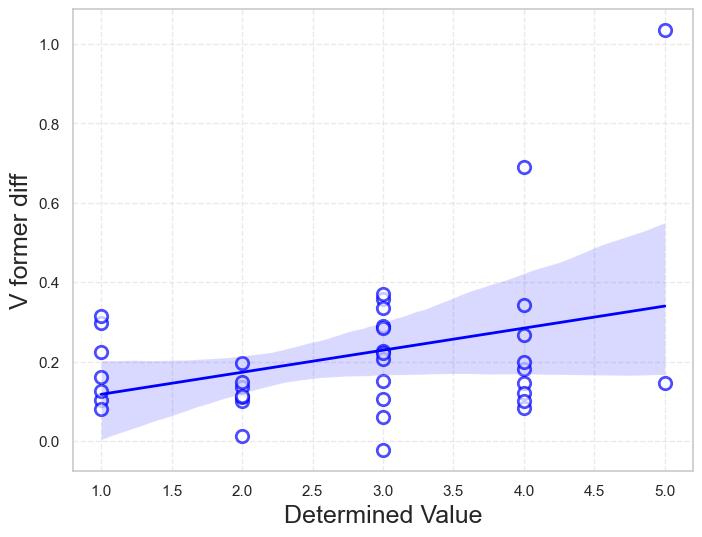

In [64]:
df_hddm_reward_final = pd.concat([df_reward_final, hddm_para_reward], axis=1)
plot_correlation(df_hddm_reward_final, 'Determined', 'v_former_diff', 'Determined Value','V former diff')


In [66]:
print("Significant correlations with v_diff in punish condition:")
sig_punish = check_significant_correlations_with_variable(corr_value_p, df_pvalue_p, 'v_diff')
print(sig_punish)

print("Significant correlations with v_former_diff in punish condition:")
sig_punish = check_significant_correlations_with_variable(corr_value_p, df_pvalue_p, 'v_former_diff')
print(sig_punish)

Significant correlations with v_diff in punish condition:
                Variable  Correlation  P-value
3      lierate_dishonest       -0.615   0.0000
6     lie_entropy_random       -0.584   0.0000
5         lierate_random       -0.541   0.0000
4  lie_entropy_dishonest        0.460   0.0004
7                  z_ses        0.312   0.0203
2        rt_drop_honesty       -0.298   0.0271
1      meta_drop_honesty        0.293   0.0297
0    lie_entropy_honesty        0.267   0.0490
Significant correlations with v_former_diff in punish condition:
                Variable  Correlation  P-value
2      v_former_diff_ses        0.710   0.0000
0  lie_entropy_dishonest       -0.382   0.0040
4                  z_ses        0.302   0.0250
3             v_diff_ses        0.274   0.0428
1    meta_drop_dishonest        0.269   0.0468


In [67]:
print("Significant correlations with v_diff in punish condition:")
sig_mixed = check_significant_correlations_with_variable(corr_value_m, df_pvalue_m, 'v_diff')
print(sig_mixed)

print("Significant correlations with v_former_diff in punish condition:")
sig_mixed = check_significant_correlations_with_variable(corr_value_m, df_pvalue_m, 'v_former_diff')
print(sig_mixed)

Significant correlations with v_diff in punish condition:
                Variable  Correlation  P-value
4         lierate_random        0.724   0.0000
1      lierate_dishonest        0.708   0.0000
5     lie_entropy_random        0.612   0.0000
3      rt_drop_dishonest       -0.517   0.0005
6                  z_ses       -0.486   0.0013
2  lie_entropy_dishonest       -0.392   0.0112
0                 Strong       -0.351   0.0243
Significant correlations with v_former_diff in punish condition:
             Variable  Correlation  P-value
1  lie_entropy_random       -0.399   0.0098
2               a_ses        0.358   0.0216
0            Inspired        0.323   0.0391


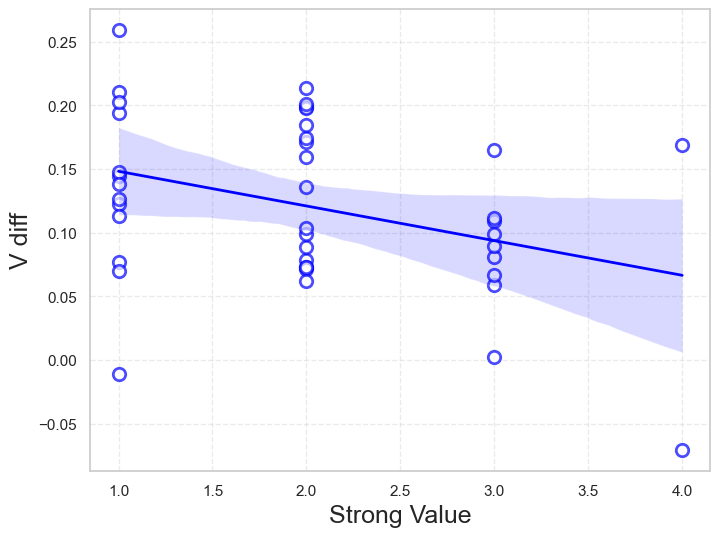

In [68]:
df_hddm_mixed_final = pd.concat([df_mixed_final, hddm_para_mixed], axis=1)
plot_correlation(df_hddm_mixed_final, 'Strong', 'v_diff', 'Strong Value','V diff')